In [1]:
using WAV
using GLMakie
using DSP

In [2]:
y, Fs, nbits, opts  = wavread("/Users/darwin/Downloads/Unknown-3.wav")

([0.00640888698995941; 0.0043641468550675985; … ; 0.0; 0.0;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [3]:
function make_resonator(f₀, fₛ, q)
    k = f₀/fₛ
    ω₀ = 2π*k
    α = sin(ω₀)/(2q)
    
    b₀ = α
    b₁ = 0.0
    b₂ = -α
    
    a₀ = 1 + α
    a₁ = -2cos(ω₀)
    a₂ = 1 - α
    
    return (b₀/a₀, b₁/a₀, b₂/a₀), (a₁/a₀, a₂/a₀)
end

make_resonator (generic function with 1 method)

In [4]:
function update_system(x, prev, feedforward_coeffs, feedback_coeffs)
    b₀, b₁, b₂ = feedforward_coeffs
    a₁, a₂ = feedback_coeffs # a₀ is assumed to be normalized to 1
    x₋, y₋ = prev

    # Apply the biquad filter equation
    y = b₀*x + b₁*x₋[2] + b₂*x₋[1] - a₁*y₋[2] - a₂*y₋[1]

    # Update state
    return y, ((x₋[2], x), (y₋[2], y))
end

update_system (generic function with 1 method)

In [5]:
candidates = 41.20344 .*[2^(i/12) for i in 1:3:12];

In [6]:
energies = []
fig = Figure()
ax = Axis(fig[1, 1], yautolimitmargin = (0.1, 0.1), xautolimitmargin = (0.1, 0.1))

n_sum = 2205
for (n, f) in enumerate(candidates)
    x₋ = (0.0, 0.0)
    y₋ = (0.0, 0.0)
    old_states = []
    sys = []
    e = zeros(n_sum)
    Σe = 0.0
    energy = zeros(length(y))
    feedforward_coeffs, feedback_coeffs = make_resonator(f, Fs, 10)
    for (i, sample) in enumerate(y)
        push!(old_states, x₋)
        output, new_state = update_system(sample, (x₋, y₋), feedforward_coeffs, feedback_coeffs)
        x₋ = new_state[1]
        y₋ = new_state[2]
        push!(sys, output)
        e[((i-1) % n_sum) + 1] = output*output
        Σe += output*output
        Σe -= e[(i % n_sum) + 1]
        energy[i] = Σe
    end
    lines!(ax, (1:length(y))./Fs, energy)
end

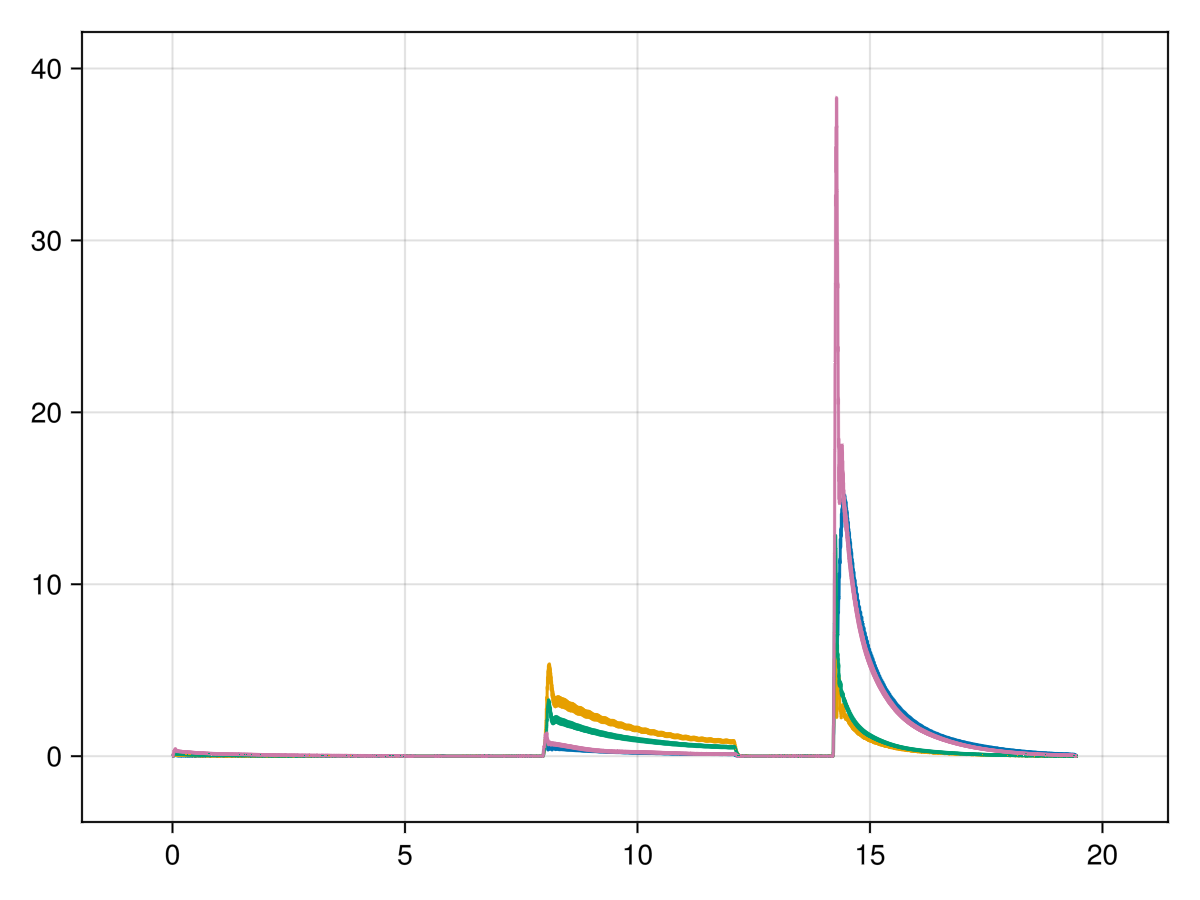

In [7]:
fig